Goal is first to compute time domain TDI with lisainstrument.

In [1]:
import os
import h5py
import logging
import scipy
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as un

from ldc.lisa.projection import ProjectedStrain, to_file, from_file
from ldc.lisa.orbits import Orbits
from ldc.waveform.waveform import HpHc

import lisaorbits

from lisainstrument import Instrument

from pytdi.michelson import X2, Y2, Z2
from pytdi import Data


Bad key "text.kerning_factor" on line 4 in
/home/philippe/.local/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution
/usr/lib/python3.8/typing.py:898: FutureWarning: xarray subclass TDI should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)


In [2]:
dt = 5 # waveform sampling
t_max = 0.1 * 60*60*24*365.25 # time of observation = 2yr
t_min = 0
print(t_min, t_max)

dt_instru = dt
physics_upsampling = 1
dt_physic = dt_instru/physics_upsampling
tvec = np.arange(t_min, t_max, dt)
print(len(tvec), t_max/dt)

0 3155760.0
631152 631152.0


In [3]:
# orbits
dto = 86400
N = int(t_max/dto)+2
L = 2.5e9 # m
path = "/home/philippe/Desktop/run2/"
o = lisaorbits.EqualArmlengthOrbit(L=L, dt=dto, size=N, tt_order=1)
os.remove(path+"orbits.h5"); o.write(path+'orbits.h5')

print(f"N={N}")

#To be used in ldc
config = {'nominal_arm_length':L, "orbit_type":'file', 'filename':path+'orbits.h5'}
orbits = Orbits.type(config)
Proj = ProjectedStrain(orbits)

N=38


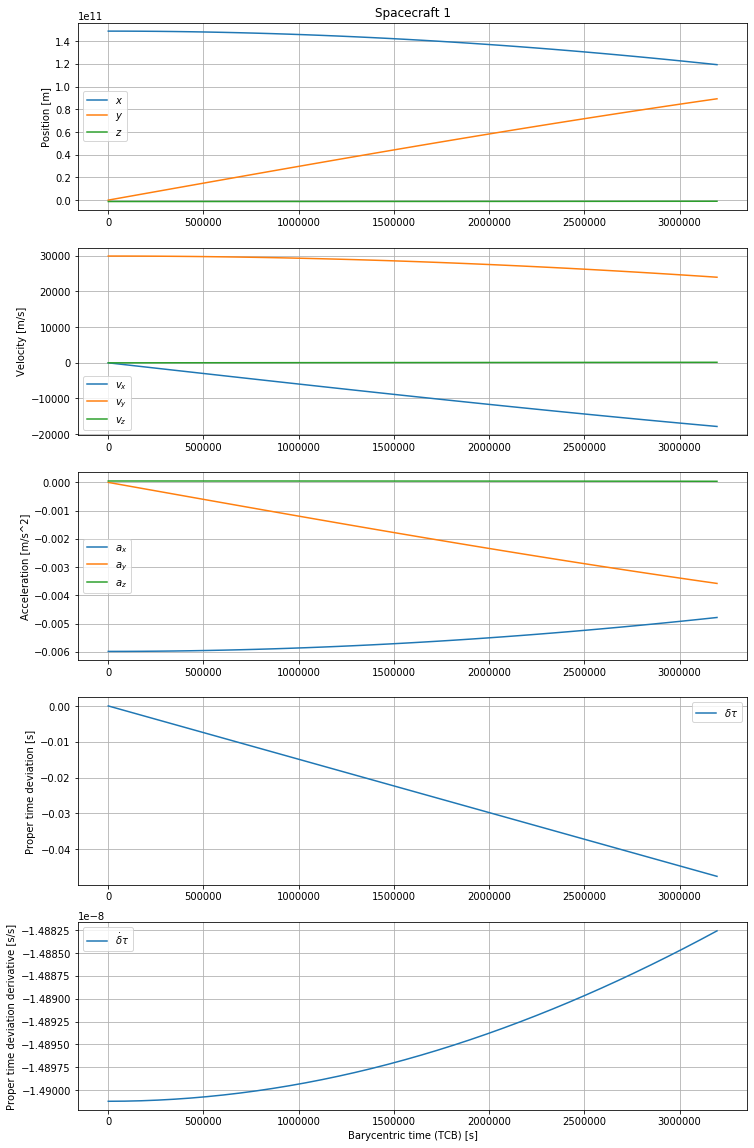

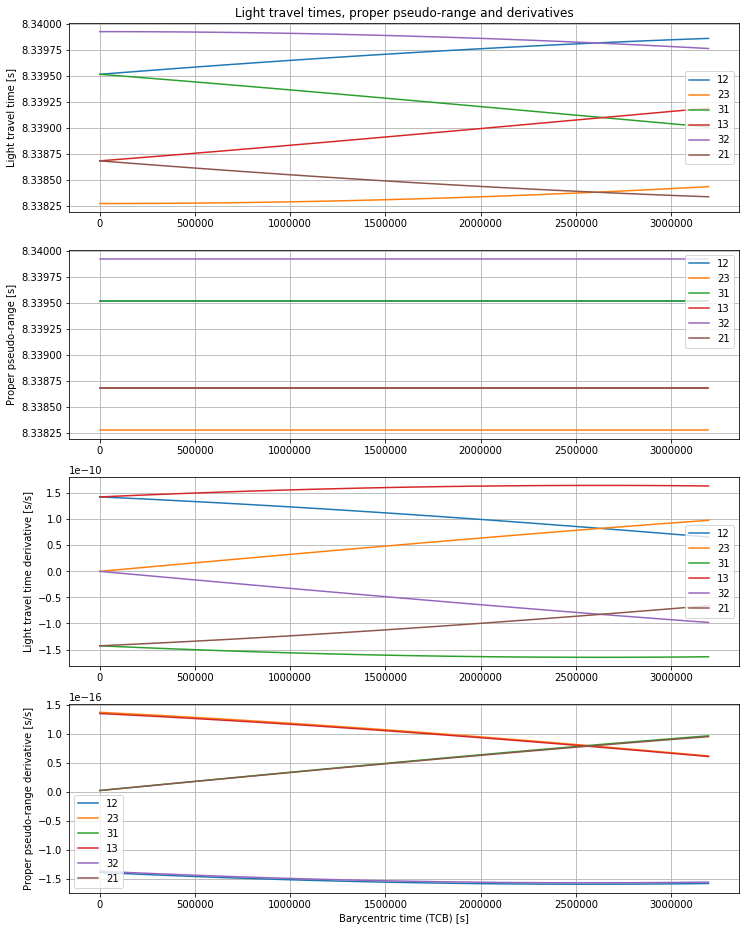

In [4]:
# plot orbits
o.plot_spacecraft(1)
o.plot_links()

In [5]:
# logger = logging.getLogger('lisainstrument')
# logger.setLevel(logging.INFO)

# strain_filename = path+"strain.h5"
# yArm, snames, links, tmin, tmax, dt = from_file(strain_filename)


# print(snames)
# print(tmin, tmax, dt)
# print(f"dt_instru={dt_instru} s | dt_physic={dt_physic}")

cat = {
    "Name": "test",
    
    'EclipticLatitude': 0.3361945823566524, 
    'EclipticLongitude': -0.8777060028716045, 
    'Mass1': 79.20437501192268, 
    'Mass2': 54.13511618304004, 
    'Spin1': -0.029308093375348003, 
    'Spin2': 0.07127380434748923, 
    'Inclination': 0.5150723317250367, 
    'InitialFrequency': 0.010450810753288828, 
    'InitialPhase': 0.0, 
    'Polarization': 5.376472875985286, 
    'Redshift': 0.0380373924232636, 
    'Distance': 174.800663606641, 
    'Cadence': 5, 
    'ObservationDuration': 63116299.52709119,
}

units= {
    'Spin1':                    '1',\
    'Spin2':                    '1',\
    'Mass1':                    'Msun',\
    'Mass2':                    'Msun',\
    'EclipticLatitude':         'rad',\
    'EclipticLongitude':        'rad',\
    'Cadence':                  's',\
    'ObservationDuration':      's',\
    'Redshift':                 '1',\
    'Distance':                 'Mpc',
}

approximant = "IMRPhenomD"
GWs = HpHc.type("my-sbbh", "SBBH", approximant)
GWs.set_param(cat, units=units); GWs = GWs.split()
yArm = Proj.arm_response(t_min, t_max, dt, GWs)
try:
    os.remove(path+"strain.h5")
except:
    pass
to_file(path+"strain.h5", yArm, cat["Name"], Proj.links, t_min, t_max, dt)

In [6]:
# write down the values of the straing + time vector
gw = {"t": np.arange(t_min, t_max+dt_physic, dt_physic)}
# gw = {"t": np.arange(tmin, tmax, dt_physic)}
print(gw["t"].size)

for j, n in enumerate(Proj.links):
    r,s = int(n[0]), int(n[-1])
    print(tvec.size, yArm[:,j].size)
    if dt != dt_physic:
#         gw[f"{r}{s}"] = scipy.interpolate.InterpolatedUnivariateSpline(tvec, yArm[:,j], k=5)(gw["t"])
        gw[f"{r}{s}"] = yArm[:,j]
    else:
        gw[f"{r}{s}"] = yArm[:,j]

631153
631152 631152
631152 631152
631152 631152
631152 631152
631152 631152
631152 631152


In [7]:
if physics_upsampling == 1:
    aafilter = None
else:
    aafilter = ('kaiser', 240, 1.1, 2.9)

N = int(t_max/dt_instru) # np.min([631100, int(tmax/dt_instru)])
print(f"aafilter={aafilter}")
print(f"N={N} | dt_instru={dt_instru}")
print(f"N*physics_upsampling={N*physics_upsampling}")

for k,v in gw.items():
    gw[k] = gw[k][0:int(N*physics_upsampling)]
    print(gw[k].shape)

aafilter=None
N=631152 | dt_instru=5
N*physics_upsampling=631152
(631152,)
(631152,)
(631152,)
(631152,)
(631152,)
(631152,)
(631152,)


In [8]:
orbit_filename = "/home/philippe/Desktop/run2/orbits.h5"
i = Instrument(physics_upsampling=physics_upsampling, t0=t_min,
               aafilter=aafilter, size=N, dt=dt_instru,
               gws=gw, orbits=orbit_filename)

In [9]:
i.t.shape

(631152,)

In [10]:
noisefree = True
lasernoise = False
doppler_effect = False
if noisefree:
    if lasernoise:
        i.disable_all_noises(but='laser')
    else:
        print(f"Disable all noises")
        i.disable_all_noises()
else:
    i.disable_clock_noises()
    
if not doppler_effect:
    print(f"Disabling doppler effect")
    i.disable_dopplers()
    
i.simulate()

assert np.allclose(i.t, tvec)

Disable all noises
Disabling doppler effect


In [11]:
# this cell takes a long time...
data = Data.from_instrument(i)
data.delay_derivative = None
# # X2_data = X2.build(**data.args)
# # Y2_data = Y2.build(**data.args)
# # Z2_data = Z2.build(**data.args)
# X2_data = X2.build(**data.args_nodoppler)
# Y2_data = Y2.build(**data.args_nodoppler)
# Z2_data = Z2.build(**data.args_nodoppler)

In [12]:
# i.plot_fluctuations()

In [13]:
# see cell 27 of https://gitlab.in2p3.fr/LISA/LDC/-/blob/spritz/data_generation/spritz/demo.ipynb
central_freq = i.central_freq # 2.816E14
# X2_pytdi = X2_data(data.measurements) / central_freq
# Y2_pytdi = Y2_data(data.measurements) / central_freq
# Z2_pytdi = Z2_data(data.measurements) / central_freq

In [14]:
# plot TDI computed with lisainstruments
# fig, ax = plt.subplots(3, sharex=True)

# ax[0].plot(i.t, X2_pytdi, label="X")
# ax[0].set_ylabel("TDI X")
# ax[0].grid()

# ax[1].plot(i.t, Y2_pytdi, label="Y")
# ax[1].set_ylabel("TDI Y")
# ax[1].grid()

# ax[2].plot(i.t, Z2_pytdi, label="Z")
# ax[2].set_xlabel("time (s)")
# ax[2].set_ylabel("TDI Z")
# ax[2].grid()

# plt.legend()
# plt.show()

In [15]:
# storing tdi in HDF5 file
# with h5py.File(args.output, 'w') as hdf5:
#     data = np.vstack((tvec, X2_ts, Y2_ts, Z2_ts)).T
#     hdf5.create_dataset('XYZ', data=data)

Now I compare the result with TDI generated by LDC pipeline routines with TDI2 (!)

In [16]:
from ldc.waveform.source.catio import load_sobbh_catalog
from ldc.lisa.projection import ProjectedStrain
from ldc.waveform.waveform import HpHc
from ldc.common.series.timeseries import TimeSeries

In [17]:
# Proj = ProjectedStrain(orbits)
# Proj.from_file(path+"strain.h5")

# assert np.allclose(Proj.yArm, yArm)
# assert np.allclose(Proj.t_min, t_min)
# assert np.allclose(Proj.t_max, t_max)

In [18]:
# tdi2 = True
# X2_ldc = TimeSeries(Proj.compute_tdi_x(tvec, tdi2=tdi2), dt=dt)
# Y2_ldc = TimeSeries(Proj.compute_tdi_y(tvec, tdi2=tdi2), dt=dt)
# Z2_ldc = TimeSeries(Proj.compute_tdi_z(tvec, tdi2=tdi2), dt=dt)

In [19]:
# compute overlaps
# def overlap(x, y):
#     xy_dot_term = np.dot(x, y)
#     xx_dot_term = np.dot(x, x)
#     yy_dot_term = np.dot(y, y)
#     return xy_dot_term / np.sqrt(xx_dot_term * yy_dot_term)
    
# O_tdi2_X = overlap(X2_pytdi, X2_ldc)
# O_tdi2_Y = overlap(Y2_pytdi, Y2_ldc)
# O_tdi2_Z = overlap(Z2_pytdi, Z2_ldc)

# print(f"Overlap X= {O_tdi2_X}")
# print(f"Overlap Y= {O_tdi2_Y}")
# print(f"Overlap Z= {O_tdi2_Z}")

In [20]:
# # a, b = 5000, 6000
# a, b = 99000, 100000

# fig, ax = plt.subplots(3, sharex=True, figsize=(15, 15))

# import numpy as np
# ax[0].plot(i.t[a:b], X2_pytdi[a:b], label="lisainstrument")
# ax[0].plot(tvec[a:b], X2_ldc[a:b], label="LDC")
# ax[0].set_ylabel("Strain amplitude")
# ax[0].set_title("TDI Z")
# ax[0].legend()
# ax[0].grid()

# ax[1].plot(i.t[a:b], Y2_pytdi[a:b], label="lisainstrument")
# ax[1].plot(tvec[a:b], Y2_ldc[a:b], label="LDC")
# ax[1].set_ylabel("Strain amplitude")
# ax[1].set_title("TDI Z")
# ax[1].legend()
# ax[1].grid()

# ax[2].plot(i.t[a:b], Z2_pytdi[a:b], label="lisainstrument")
# ax[2].plot(tvec[a:b], Z2_ldc[a:b], label="LDC")
# ax[2].set_xlabel("time (s)")
# ax[2].set_ylabel("Strain amplitude")
# ax[2].set_title("TDI Z")
# ax[2].legend()
# ax[2].grid()

# plt.show()

Now I repeat the comparison with TDI1

In [21]:
from pytdi.michelson import X1, Y1, Z1

In [22]:
X1_data = X1.build(**data.args_nodoppler)
Y1_data = Y1.build(**data.args_nodoppler)
Z1_data = Z1.build(**data.args_nodoppler)

In [23]:
X1_pytdi = X1_data(data.measurements) / central_freq
Y1_pytdi = Y1_data(data.measurements) / central_freq
Z1_pytdi = Z1_data(data.measurements) / central_freq

In [24]:
tdi2 = False
X1_ldc = TimeSeries(Proj.compute_tdi_x(tvec, tdi2=tdi2), dt=dt)
Y1_ldc = TimeSeries(Proj.compute_tdi_y(tvec, tdi2=tdi2), dt=dt)
Z1_ldc = TimeSeries(Proj.compute_tdi_z(tvec, tdi2=tdi2), dt=dt)

In [25]:
# compute overlaps
def overlap(x, y):
    xy_dot_term = np.dot(x, y)
    xx_dot_term = np.dot(x, x)
    yy_dot_term = np.dot(y, y)
    return xy_dot_term / np.sqrt(xx_dot_term * yy_dot_term)
    
O_tdi1_X = overlap(X1_pytdi, X1_ldc)
O_tdi1_Y = overlap(Y1_pytdi, Y1_ldc)
O_tdi1_Z = overlap(Z1_pytdi, Z1_ldc)

print(f"Overlap X= {O_tdi1_X}")
print(f"Overlap Y= {O_tdi1_Y}")
print(f"Overlap Z= {O_tdi1_Z}")

Overlap X= 0.9999979000431107
Overlap Y= 0.9999959817110747
Overlap Z= 0.9999960298599095


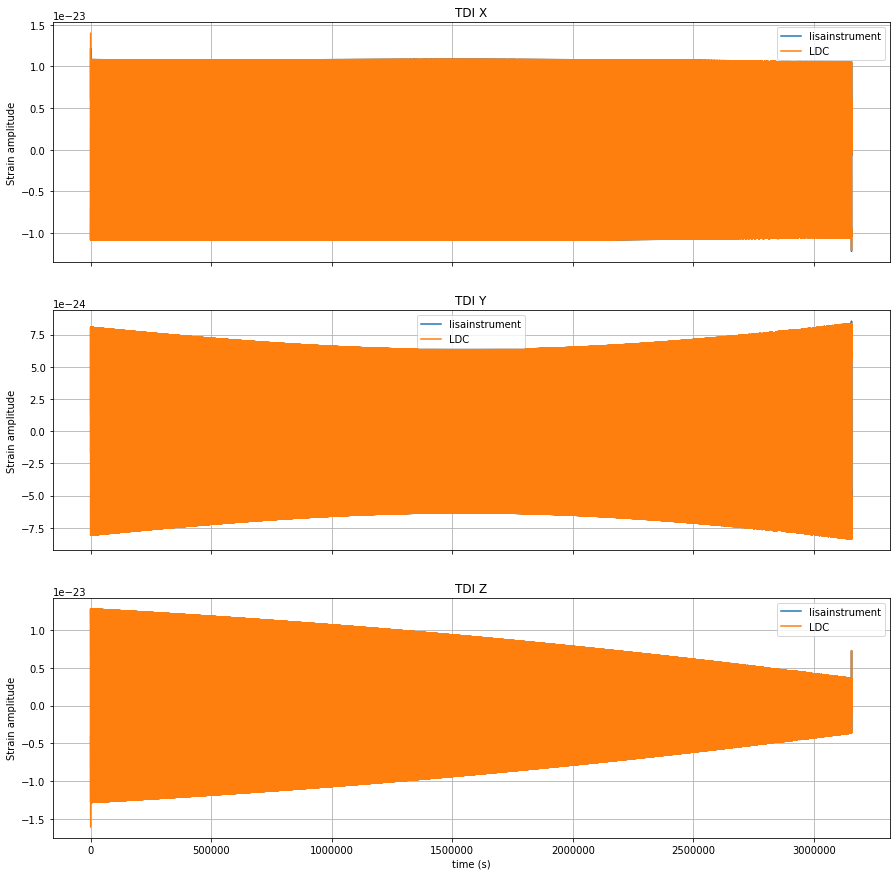

In [30]:
# a, b = 5000, 6000
# a, b = 99000, 100000
# a, b = 0, 1000
# a, b = len(X1_ldc) - 1000, len(X1_ldc)-1
a, b = 0, len(X1_ldc)-1

fig, ax = plt.subplots(3, sharex=True, figsize=(15, 15))

import numpy as np
ax[0].plot(i.t[a:b], X1_pytdi[a:b], label="lisainstrument")
ax[0].plot(tvec[a:b], X1_ldc[a:b], label="LDC")
ax[0].set_ylabel("Strain amplitude")
ax[0].set_title("TDI X")
ax[0].legend()
ax[0].grid()

ax[1].plot(i.t[a:b], Y1_pytdi[a:b], label="lisainstrument")
ax[1].plot(tvec[a:b], Y1_ldc[a:b], label="LDC")
ax[1].set_ylabel("Strain amplitude")
ax[1].set_title("TDI Y")
ax[1].legend()
ax[1].grid()

ax[2].plot(i.t[a:b], Z1_pytdi[a:b], label="lisainstrument")
ax[2].plot(tvec[a:b], Z1_ldc[a:b], label="LDC")
ax[2].set_xlabel("time (s)")
ax[2].set_ylabel("Strain amplitude")
ax[2].set_title("TDI Z")
ax[2].legend()
ax[2].grid()

plt.show()

In [27]:
# filename = "/home/philippe/Desktop/TDI1.5_SBBH_SNR_27.72_Tobs_2yrs.hdf5"
# with h5py.File(filename, 'w') as hdf5:
#     hdf5.create_dataset('XYZ', data=np.vstack((i.t, X1_ldc, Y1_ldc, Z1_ldc)).T)

In [28]:
i.t.shape

(631152,)

In [29]:
X1_ldc.shape

(631152,)